<a href="https://colab.research.google.com/github/FajarRamadhanBBX/Bank-Customer-Churn/blob/main/Bank_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tujuan: Membuat model untuk mendeteksi apakah nasabah akan keluar atau tidak

Pertanyaan bisnis <br>
1. Bagaimana cara mempertahankan pelanggan?
2. Apa yang menyebabkan customer memutuskan untuk keluar?

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Import modul

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Persiapan data

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Portofolio/Data Science/Customer-Churn-Records.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


Fungsi dibawah ini akan digunakan untuk membagi data yang kategorial dengan data numerik

In [5]:
def catColumns(data):
    catCol = []
    for cat in data.columns:
        if data[cat].dtype == np.object_:
            catCol.append(cat)
    return catCol

def numColumns(data):
    numCol = []
    for num in data.columns:
        if data[num].dtype in [np.int64, np.float64]:
            numCol.append(num)
    return numCol

data_cat = catColumns(data)
data_num = numColumns(data)

# Exploratory Data Analysis

## Korelasi linear antar fitur

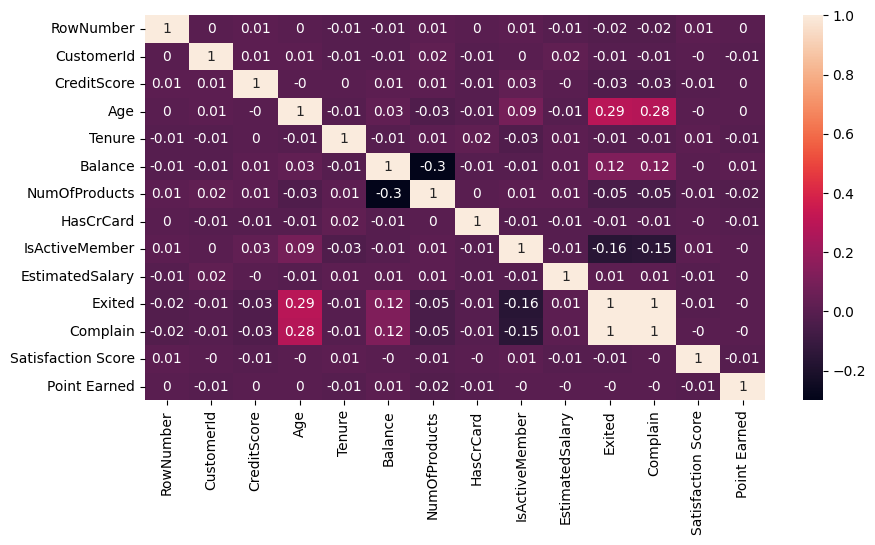

In [6]:
plt.figure(figsize=(10,5))
data_corr = data[data_num].corr()
sns.heatmap(round(data_corr,2), annot=True)
plt.show()

Dari gambar tersebut diketahui bahwa pada umumnya tidak terdapat korelasi antar fitur secara linear. Namun, terdapat beberapa fitur yang memiliki korelasi yang lemah (0.1 < r <= 0.3), seperti:
<br>
- Age dengan Complain
- Age dengan Exited
- Balance dengan Complain
- Balance dengan Exited
- Balance dengan NumOfProduct <br>
<br>
Selain itu, terdapat satu hubungan yang memiliki korelasi sempurna (r = 1), yaitu fitur Exited dengan Complain.

## Hubungan pelanggan yang komplain dengan status pelanggan

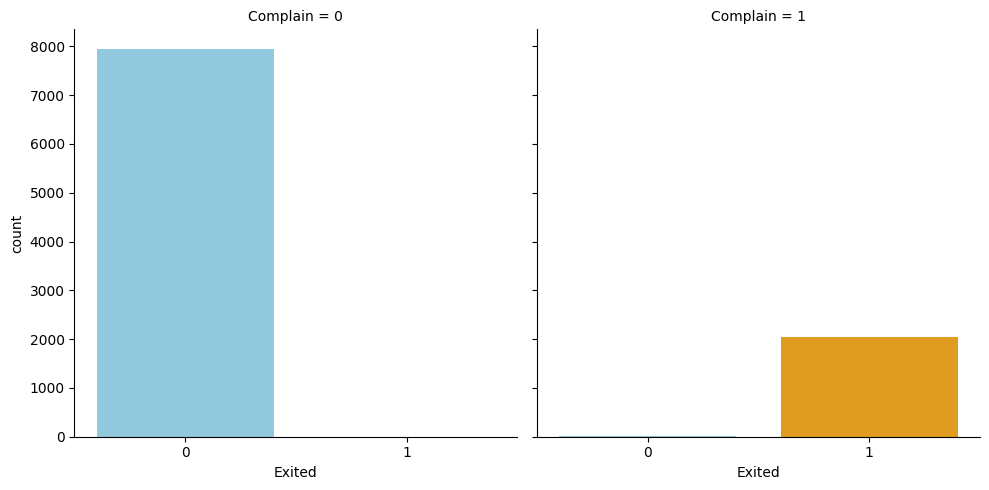

In [7]:
sns.catplot(data=data, kind='count', x='Exited', col='Complain', palette=['skyblue','orange'])

In [8]:
data_complain = data[data['Complain'] == 1]
data_complain_exited = len(data_complain[data_complain['Exited'] == 1])
print('Persentase data yang komplain dan keluar:')
res = (data_complain_exited/len(data_complain))*100
print(f"{round(res, 2)}%")

data_not_complain = data[data['Complain'] == 0]
data_not_complain_not_exited = len(data_not_complain[data_not_complain['Exited'] == 0])
print('Persentase data yang tidak komplain dan tidak keluar:')
res = (data_not_complain_not_exited/len(data_not_complain))*100
print(f"{round(res, 2)}%")

Persentase data yang komplain dan keluar:
99.51%
Persentase data yang tidak komplain dan tidak keluar:
99.95%


Dari data yang terlihat, diketahui bahwa hampir semua orang yang melakukan komplain berstatus pelanggan keluar.
Maka dari itu, strategi bisnis yang dapat digunakan untuk menekan angka pelanggan yang keluar adalah dengan menekan angka komplain.

## Hubungan antara tipe kartu pelanggan dengan status pelanggan

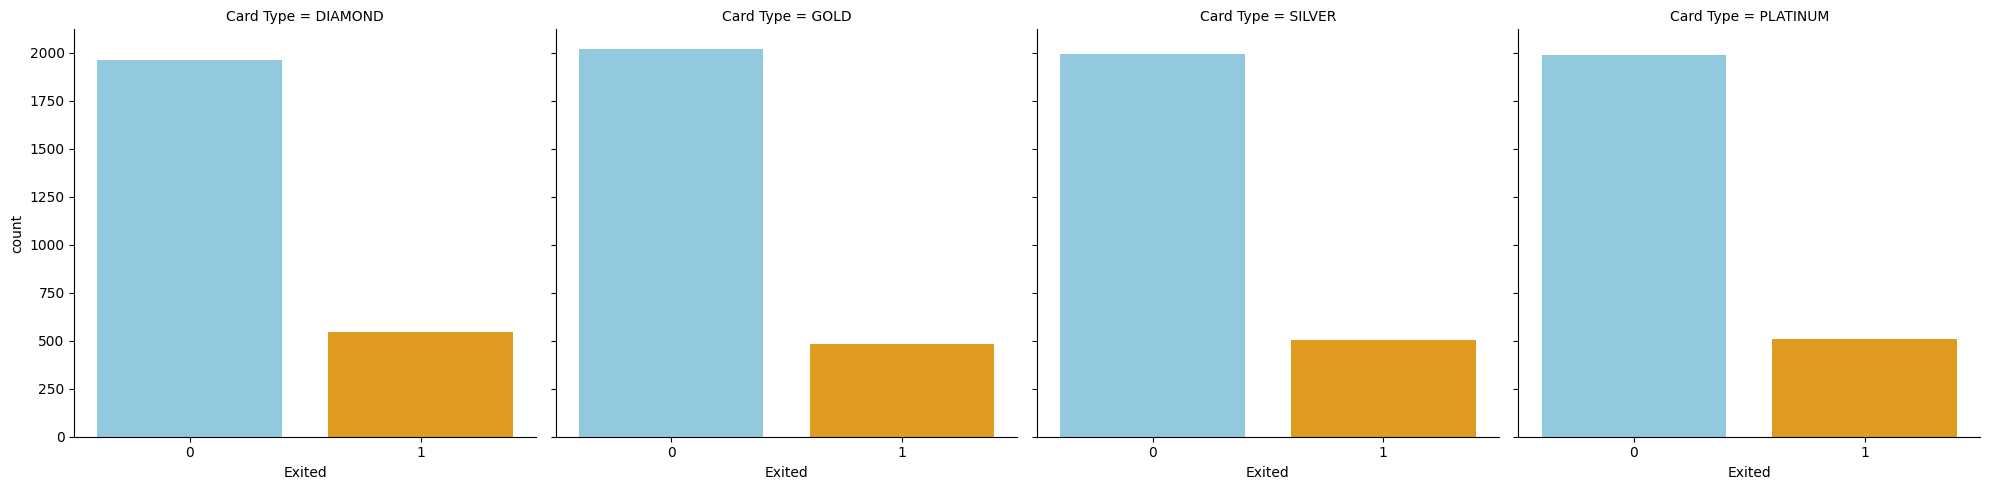

In [9]:
sns.catplot(data=data, kind='count', x='Exited', col='Card Type', palette=['skyblue','orange'])

Sebaran tipe kartu yang digunakan cenderung serupa baik untuk pelanggan yang bertahan maupun pelanggan yang keluar

# Rata-rata skor kredit pelanggan

<Axes: >

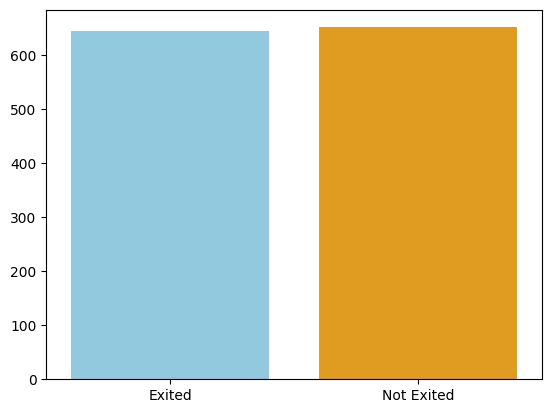

In [10]:
avg_credit_exited = data.loc[data['Exited'] == 1, 'CreditScore'].mean()
avg_credit_not_exited = data.loc[data['Exited'] == 0, 'CreditScore'].mean()

labels = ['Exited', 'Not Exited']
satisfaction_mean = np.array([avg_credit_exited, avg_credit_not_exited])

sns.barplot(x=labels, y=satisfaction_mean, palette=['skyblue','orange'])

baik pelanggan yang bertahan dan pelanggan yang keluar memiliki rata-rata skor kredit yang cenderung sama, sehingga dapat diartikan bahwa skor kredit tidak terlalu mempengaruhi keputusan pelanggan untuk keluar.

# Rata-rata *balance* pelanggan

<Axes: >

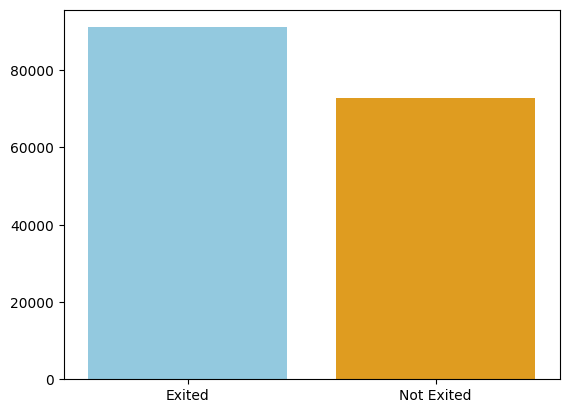

In [11]:
avg_balance_exited = data.loc[data['Exited'] == 1, 'Balance'].mean()
avg_balance_not_exited = data.loc[data['Exited'] == 0, 'Balance'].mean()

labels = ['Exited', 'Not Exited']
satisfaction_mean = np.array([avg_balance_exited, avg_balance_not_exited])

sns.barplot(x=labels, y=satisfaction_mean, palette=['skyblue','orange'])

Dapat dilihat *balance* yang dimilki pelanggan yang bertahan justru memiliki rataan yang lebih kecil dibandingkan dengan pelanggan yang keluar

# Rata-rata nilai kepuasan pelanggan

<Axes: >

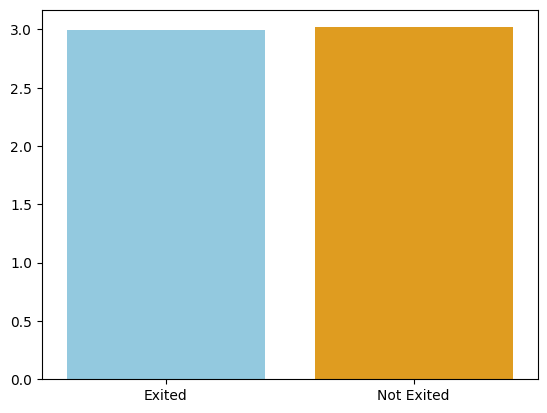

In [12]:
avg_satisfaction_exited = data.loc[data['Exited'] == 1, 'Satisfaction Score'].mean()
avg_satisfaction_not_exited = data.loc[data['Exited'] == 0, 'Satisfaction Score'].mean()

labels = ['Exited', 'Not Exited']
satisfaction_mean = np.array([avg_satisfaction_exited, avg_satisfaction_not_exited])

sns.barplot(x=labels, y=satisfaction_mean, palette=['skyblue','orange'])

Rata-rata nilai kepuasan pengguna baik yang bertahan maupun keluar cenderung tidak berbeda, yaitu berada disekitar angka 3.

## Hubungan antara gender pelanggan dan kepemilikan kartu dengan status pelanggan

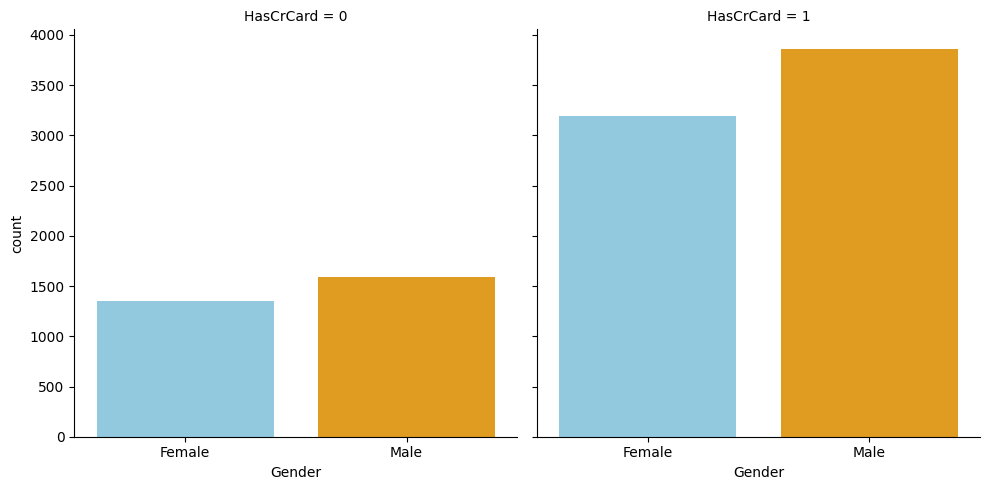

In [13]:
sns.catplot(data=data, kind='count', x='Gender', col='HasCrCard', palette=['skyblue','orange'])

Diketahui kebanyakan customer berjenis kelamin pria dan jumlah pria baik yang memiliki atau tidak memiliki kartu kredit lebih tinggi dari wanita

## Sebaran tipe kartu kredit pelanggan

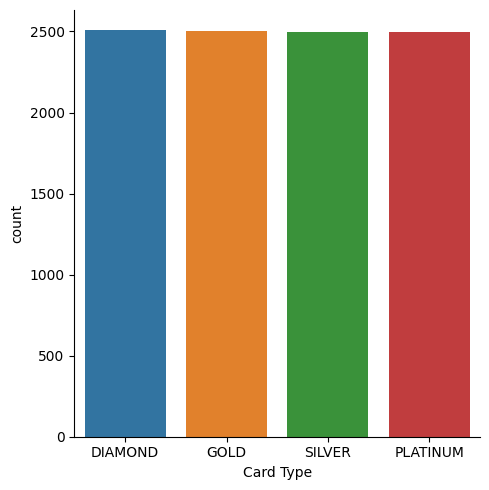

In [14]:
sns.catplot(data=data, kind='count', x='Card Type', hue='Card Type')

Jumlah tipe kartu kredit yang digunakan oleh pelanggan cenderung sama

## Hubungan geografi dengan tipe kartu kredit

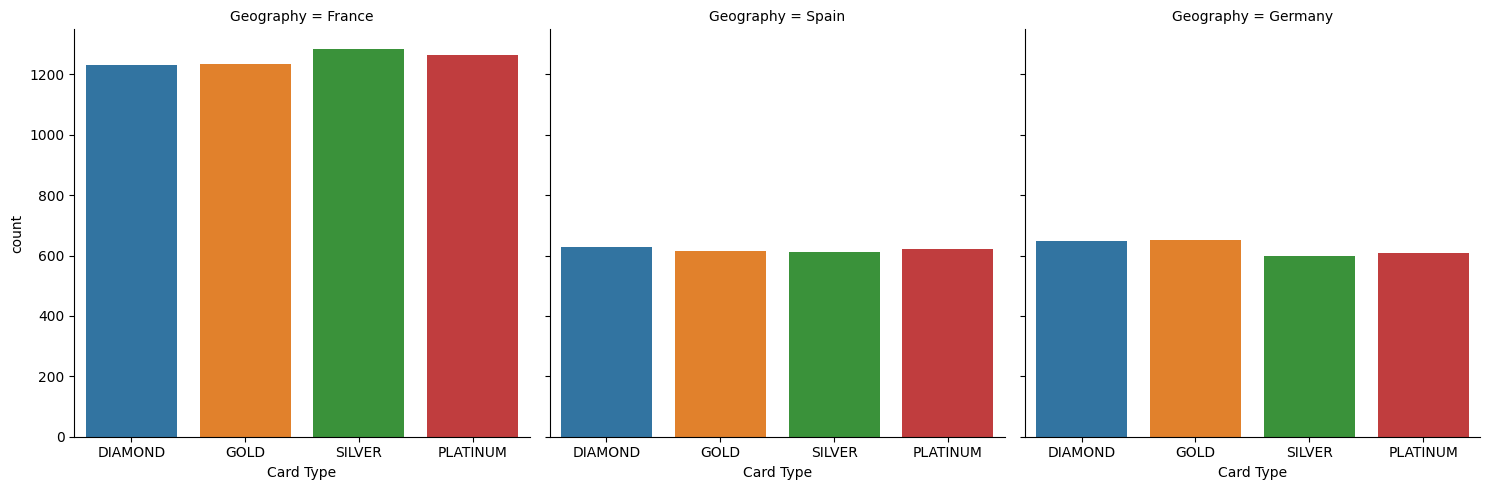

In [15]:
sns.catplot(data=data, kind='count', x='Card Type', col='Geography', hue='Card Type')
plt.show()

Dari 3 negara, negara Prancis merupakan negara yang memiliki paling banyak customer. Sedangkan 2 negara lainnya (Spanyol dan Jerman) memiliki jumlah pengguna yang hampir sama pada tiap tipe kartu dengan jumlah masing-masing kedua negara kurang lebih setengah pengguna di Prancis

# Data Pre-Processing

## Melihat informasi mengenai data

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

## Cek data yang duplikat

In [17]:
data['CustomerId'].duplicated().sum()

0

## Cek data yang kosong

In [18]:
data.isnull().sum()

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

## Menghapus fitur yang tidak dibutuhkan

In [19]:
df = data.copy()
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


Fitur-fitur yang tidak berguna dalam pemodelan dihapus untuk meringankan beban komputasi

## Melihat ringkasan data

In [20]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,0.204400,3.013800,606.515100
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,0.403283,1.405919,225.924839
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,1.000000,119.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,2.000000,410.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,3.000000,605.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,0.000000,4.000000,801.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,5.000000,1000.000000


## Transformasi data

### Menyiapkan label atau nama kolom

In [21]:
numerical_label = numColumns(df)
one_hot_label = ['Gender','Geography']
label_encoding_label = ['Card Type']

### Melakukan normalisasi data

In [22]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
numerical_data = df[numerical_label]

numerical_data = scaler.fit_transform(numerical_data)
numerical_data = pd.DataFrame(numerical_data, columns=numerical_label)
numerical_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
0,-0.246269,0.416667,-0.75,-0.761480,0.0,0.0,0.0,0.011739,1.0,1.0,-0.5,-0.360614
1,-0.328358,0.333333,-1.00,-0.104906,0.0,-1.0,0.0,0.125512,0.0,1.0,0.0,-0.381074
2,-1.119403,0.416667,0.75,0.489346,2.0,0.0,-1.0,0.139630,1.0,1.0,0.0,-0.583120
3,0.350746,0.166667,-1.00,-0.761480,1.0,-1.0,-1.0,-0.064717,0.0,0.0,1.0,-0.652174
4,1.477612,0.500000,-0.75,0.221806,0.0,0.0,0.0,-0.214561,0.0,0.0,1.0,-0.460358


Pada data numerik, data dinormalisasi menggunakan metode Robust Scaler guna meminimalisir pengaruh skala atau outliers

### One-Hot Encoding

In [23]:
one_hot_data = pd.get_dummies(df[one_hot_label])
one_hot_data.head()

,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain
0,True,False,True,False,False
1,True,False,False,False,True
2,True,False,True,False,False
3,True,False,True,False,False
4,True,False,False,False,True


Untuk fitur yang kategorikal namun tidak dapat diurutkan, normalisasi digunakan dengan menggunakan One-Hot Encoding

In [24]:
one_hot_map = {
    True : 1,
    False : 0
}

one_hot_data = one_hot_data.replace(one_hot_map)
one_hot_data.head()

,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain
0,1,0,1,0,0
1,1,0,0,0,1
2,1,0,1,0,0
3,1,0,1,0,0
4,1,0,0,0,1


### Label Encoding

In [25]:
label_encoding_map = {
    'SILVER': 1,
    'GOLD': 2,
    'DIAMOND': 3,
    'PLATINUM': 4
}

label_encoding_data = df[label_encoding_label].replace(label_encoding_map)
label_encoding_data.head()

,Card Type
0,3
1,3
2,3
3,2
4,2


Label encoding dilakukan pada data kategorikal yang memiliki urutan, contohnya seperti fitur tipe kartu yang dapat diurutkan berdasarkan tipenya

### Menggabungkan data hasil transformasi

In [26]:
df = pd.concat([numerical_data, one_hot_data, label_encoding_data], axis=1)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain,Card Type
0,-0.246269,0.416667,-0.75,-0.761480,0.0,0.0,0.0,0.011739,1.0,1.0,-0.5,-0.360614,1,0,1,0,0,3
1,-0.328358,0.333333,-1.00,-0.104906,0.0,-1.0,0.0,0.125512,0.0,1.0,0.0,-0.381074,1,0,0,0,1,3
2,-1.119403,0.416667,0.75,0.489346,2.0,0.0,-1.0,0.139630,1.0,1.0,0.0,-0.583120,1,0,1,0,0,3
3,0.350746,0.166667,-1.00,-0.761480,1.0,-1.0,-1.0,-0.064717,0.0,0.0,1.0,-0.652174,1,0,1,0,0,2
4,1.477612,0.500000,-0.75,0.221806,0.0,0.0,0.0,-0.214561,0.0,0.0,1.0,-0.460358,1,0,0,0,1,2


# Pembuatan Model

Dari hasil EDA, diketahui bahwa faktor utama dari keluar atau tidaknya pelanggan adalah komplain. Jika seorang pelanggan komplain,
maka kemungkinan besar pelanggan akan keluar, begitupun sebaliknya. Maka dari itu, model yang dibuat akan memprediksi apakah seorang
pelanggan akan komplain atau tidak dengan berdasarkan fitur yang disediakan.

## Deklarasi fitur dan label yang akan digunakan

In [27]:
X = df.drop(['Complain', 'Exited'], axis=1)
y = df.loc[:, ('Complain')]

## Membagi data

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

data dibagi menjadi 80% untuk melakukan training dan 20% sisanya untuk melakukan testing

## Mencari paramater model terbaik

In [29]:
def xgb_grid_search(X,y,nfolds):
    param_grid = {'criterion':['gini','entropy'],'max_depth': np.arange(3, 10)}
    xgb_model = XGBClassifier()
    xgb_gscv = GridSearchCV(xgb_model, param_grid, cv=nfolds)
    xgb_gscv.fit(X, y)
    return xgb_gscv.best_params_

In [30]:
best_params = xgb_grid_search(X_train, y_train, 5)
best_params

{'criterion': 'gini', 'max_depth': 3}

Model dibuat menggunakan XGBoost classifier, yaitu salah satu model yang dapat digunakan untuk melakukan klasifikasi. Pada kasus ini, diketahui parameter terbaik yang dapat digunakan yaitu dengan kriteria 'gini' dan maksimal kedalamannya 3

## Deklarasi model

In [31]:
model = XGBClassifier(criterion='gini', max_depth=3)

## Melatih model

In [32]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, criterion='gini', device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## Evaluasi model

In [33]:
y_predicted = model.predict(X_test)

In [34]:
def evaluationModel(y_true, y_pred):
    cn = confusion_matrix(y_true, y_pred)
    sns.heatmap(cn, annot=True,fmt='.2f')
    plt.show()
    cr = classification_report(y_true, y_pred)
    print(cr)

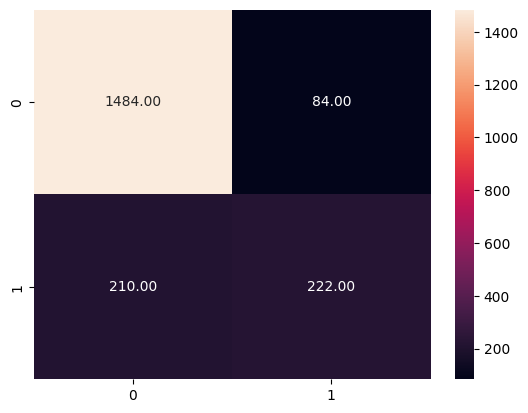

              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91      1568
         1.0       0.73      0.51      0.60       432

    accuracy                           0.85      2000
   macro avg       0.80      0.73      0.76      2000
weighted avg       0.84      0.85      0.84      2000



In [35]:
evaluationModel(y_test, y_predicted)

Hasil evaluasi menggunakan Confusion matrix menunjukan bahwa model masih perlu dievaluasi, hal ini dikarenakan masih besarnya nilai False Negative. Hal ini juga ditunjukan dengan kecilnya nilai recall pada data berlabel 1.

# Mencoba melakukan prediksi

In [36]:
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Point Earned,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain,Card Type
0,-0.246269,0.416667,-0.75,-0.761480,0.0,0.0,0.0,0.011739,-0.5,-0.360614,1,0,1,0,0,3
1,-0.328358,0.333333,-1.00,-0.104906,0.0,-1.0,0.0,0.125512,0.0,-0.381074,1,0,0,0,1,3
2,-1.119403,0.416667,0.75,0.489346,2.0,0.0,-1.0,0.139630,0.0,-0.583120,1,0,1,0,0,3
3,0.350746,0.166667,-1.00,-0.761480,1.0,-1.0,-1.0,-0.064717,1.0,-0.652174,1,0,1,0,0,2
4,1.477612,0.500000,-0.75,0.221806,0.0,0.0,0.0,-0.214561,1.0,-0.460358,1,0,0,0,1,2


# Mencoba melakukan prediksi

In [40]:
pred = model.predict([[200, 30, 3, 100000, 1, 0, 1, 600000, 5, 1324234, 1,0,1,0,0,4]])

if pred == 1:
    print('Pelanggan berpotensi komplain')
elif pred == 0:
    print('Pelanggan tidak berpotensi komplain')

Pelanggan tidak berpotensi komplain
